In [1]:
import tensorflow

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [3]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten

In [4]:
import matplotlib.pyplot as plt

In [5]:
(train_image, train_label), (_, _) = tensorflow.keras.datasets.mnist.load_data()

In [6]:
train_image.shape

(60000, 28, 28)

In [7]:
train_image = train_image.reshape(train_image.shape[0], 28, 28, 1).astype('float32')

In [8]:
train_image.shape

(60000, 28, 28, 1)

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
train_dataset = tensorflow.data.Dataset.from_tensor_slices(train_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Generator Model

In [11]:
#model = tensorflow.keras.Sequential()

In [12]:
def generotor_model():
    model = tensorflow.keras.Sequential()
    model.add(Dense(7*7*256, use_bias = False, input_shape = (100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128) 
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 14, 14, 64) 
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5,5), strides = (2,2), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    print(model.summary())
    return model

In [13]:
generator = generotor_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

Generate Sample Image

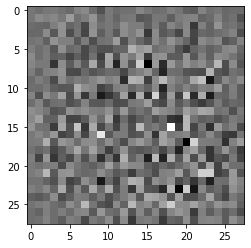

In [14]:
noise = tensorflow.random.normal([1,100])
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

Discrimnator Model

In [15]:
def discriminator_model():
    model = tensorflow.keras.Sequential()
    model.add(Conv2D(64,(5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    print(model.summary())
    return model

In [16]:
discriminator = discriminator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Computing Loss

In [17]:
cross_entropy = tensorflow.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tensorflow.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tensorflow.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tensorflow.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)

Train Model

In [20]:
import os

In [21]:
checkpoint_dir = './train_checkpoints'
checkpoints_prefix = os.path.join(checkpoint_dir, "ckpt")

In [22]:
checkpoint = tensorflow.train.Checkpoint(generator_optimizer = generator_optimizer,
                                        discriminator_optimizer = discriminator_optimizer,
                                        generator = generator,
                                        discriminator = discriminator)

Training for short example

In [23]:
EPOCHS = 45
num_examples_to_generate = 16
noise_dim = 100
seed = tensorflow.random.normal([num_examples_to_generate, noise_dim])

In [24]:
@tensorflow.function
def train_steps(images):
    # create random noise
    noise = tensorflow.random.normal([BATCH_SIZE, noise_dim])
    #2 Generate images and calculate loss values
    with tensorflow.GradientTape() as gen_tape, tensorflow.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)
        
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        #3
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
import time
import PIL
from IPython import display

import glob
import imageio

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_steps(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoints_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [27]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

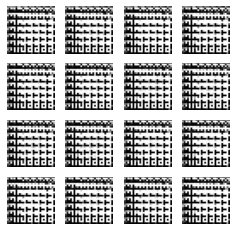

In [28]:
train(train_dataset, EPOCHS)